# Сверточные сети в задачах компьютерного зрения

**Разработчики: Артем Бабенко, Екатерина Глазкова**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aosokin/dl_cshse_ami/blob/master/2021-fall/homeworks_small/shw5/DL21-fall-shw5.ipynb)

На этом семинаре необходимо будет (1) реализовать простейшую metric learning архитектуру на основе сиамской нейросети с Contrastive Loss и (2) обучить модель UNet для задачи сегментации изображения. 

In [1]:
!wget --quiet --show-progress "https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2021-fall/homeworks_small/shw5/utils.py"
!wget --quiet --show-progress "https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2021-fall/homeworks_small/shw5/UNet.png"
!wget --quiet --show-progress "https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2021-fall/homeworks_small/shw5/cityscapes_example.png"

utils.py            100%[===================>]   5.67K  --.-KB/s    in 0s      
UNet.png            100%[===================>] 100.85K  --.-KB/s    in 0.002s  
cityscapes_example. 100%[===================>] 516.58K  --.-KB/s    in 0.005s  


# Metric Learning (0.5 баллов)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss
torch.manual_seed(0)
import random
random.seed(0)
np.random.seed(0)

Вам необходимо реализовать вычисление Contrastive Loss - одну из самых популярных функций потерь для metric learning. Contrastive Loss получает на вход пару векторов $x_i$ и $x_j$ (признаковые описания объектов $i$ и $j$, полученные нейросетью) и метку $y_{ij}$, причем $y_{ij} = 0$, если объекты "похожи" (принадлежат одному классу), и $y_{ij} = 1$, если объекты "различны" (принадлежат различным классам). Формально определим Contrastive Loss следующим образом:

$$
L(x_i, x_j, y_{ij}) = (1 - y_{ij})\|x_i - x_j\|^2 + y_{ij}max(0, m - \|x_i - x_j\|^2)
$$

где $m$ - гиперпараметр (его можно взять равным единице).

Вместо того, чтобы формировать обучающее множество из всевозможных пар, можно поступить проще: будем пропускать батч из $N$ обучаюших изображений через сеть (тем самым получая соответствующие векторы $x$), а значение лосса вычислять как среднее значение функции $L$ на всех парах в этом батче. Тогда в обучении на каждом батче участвует $\frac{N(N-1)}{2}$ пар, что существенно ускоряет сходимость на практике. Реализуйте предложенный вариант Contrastive Loss.

In [3]:
from scipy.spatial import distance_matrix
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x, y):
        # x: batch_size x num_features
        # y: batch_size
        dists = torch.cdist(x, x, p=2)
        targets = 1 * (y != y[:, None])
        total_l = torch.sum((1 - targets) * dists + targets * torch.maximum(torch.zeros_like(dists), self.margin - dists))
        n = len(y)
        return total_l / n / (n - 1)

In [4]:
x = torch.arange(6).reshape(3, 2).float()
y = torch.tensor([1, 2, 1])
cl = ContrastiveLoss(100)
cl.forward(x, y)

tensor(66.6667)

В задачах metric learning, как правило, необходимо, чтобы количества "положительных" и "отрицательных" пар в обучении отличалось несильно. Поэтому в случае большого количества классов случайное формирование батчей неэффективно - в таком случае количество "положительных" пар очень мало. Поэтому будем формировать обучающие батчи размера $N$ следующим образом: будем брать $\frac{N}{2}$ элементов из некоторого класса (они между собой будут формировать "положительные пары"), а оставшиеся $\frac{N}{2}$ элементов будем брать случайно. Таким образом мы гарантируем, что в каждом обучающем батче будет достаточно "положительных" пар.

Реализуйте предложенную логику в рамках Pytorch, реализовав собственный BatchSampler. Ваш самплер должен формировать каждый батч размера $N$ следующим образом: $\frac{N}{2}$ объектов извлекаются из некоторого случайного класса, оставшиеся $\frac{N}{2}$ объектов извлекаются случайно.

In [5]:
import random
class ContrastiveSampler(BatchSampler):
    def __init__(self, batch_size, num_classes, labels):
        self.num_classes = num_classes
        self.imgs_per_class = labels.size()[0] // num_classes
        self.batch_size=batch_size
        self.labels = labels

    def __iter__(self):
        num_yielded = 0
        while num_yielded < (self.num_classes * self.imgs_per_class):
            batch = []
            label = np.random.choice(self.labels)
            label_idx = torch.arange(len(self.labels))[self.labels == label]
            ind1 = np.random.choice(label_idx.numpy(), size=batch_size // 2, replace=True)
            ind2 = np.random.choice(np.arange(len(self.labels)), size=batch_size // 2, replace=True)
            batch = list(ind1) + list(ind2)
            random.shuffle(batch)
            num_yielded += self.batch_size
            yield batch

В этом задании будем работать с небольшими изображениями одежды из датасета Fashion-MNIST.

In [6]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.FashionMNIST(root='.', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.FashionMNIST(root='.', 
                                  train=False, 
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_sampler=ContrastiveSampler(batch_size=batch_size, num_classes=num_classes, labels=train_dataset.train_labels), 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_sampler=ContrastiveSampler(batch_size=batch_size, num_classes=num_classes, labels=test_dataset.test_labels), 
                                          shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Реализуйте сеть несложной архитектуры, содержащую три сверточных слоя из 20 фильтров с макс-пулингом, а также два полносвязных слоя из 128 нейронов. Выход последнего слоя будет подаваться на вход Contrastive Loss.

In [7]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class ContrastiveNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 20, 3, padding=1), 
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(20, 20, 3), 
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(20, 20, 3, padding=1), 
            # nn.MaxPool2d(2),
            nn.ReLU(),
            Flatten(),
            nn.Linear(6*6*20, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )

    def forward(self, x):
        output = self.cnn1(x)
        return output

In [8]:
contrastive_loss = ContrastiveLoss()

def train_epoch(model, optimizer):
    loss_log = []
    model.train()
    for batch_num, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)        
        loss = contrastive_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log   

def test(model):
    loss_log = []
    model.eval()
    for batch_num, (data, target) in enumerate(test_loader):    
        output = model(data)
        loss = contrastive_loss(output, target)
        loss = loss.item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []

    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss = train_epoch(model, opt)
        val_loss = test(model)
        train_log.extend(train_loss)
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log, val_log)

In [9]:
model = ContrastiveNetwork()

Обучите сеть с параметрами, указанными ниже.

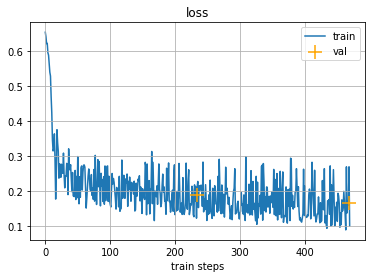

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(model, opt, 2)

Извлеките векторные описания тестовых изображений (a.k.a эмбеддинги). У вас должно получиться 10000 128-мерных векторов.

In [11]:
emb_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,
                                          shuffle=False)
model.eval()
output = []
i = 0
for batch_num, (data, target) in enumerate(emb_loader):    
    output.append(model(data))
    i = batch_num
embeddings = torch.cat(output, dim=0)
embeddings.shape

torch.Size([10000, 128])

Код ниже демонстрирует поисковую выдачу для трех изображений-запросов. Выдача формируется на основе близости эмбеддингов.

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


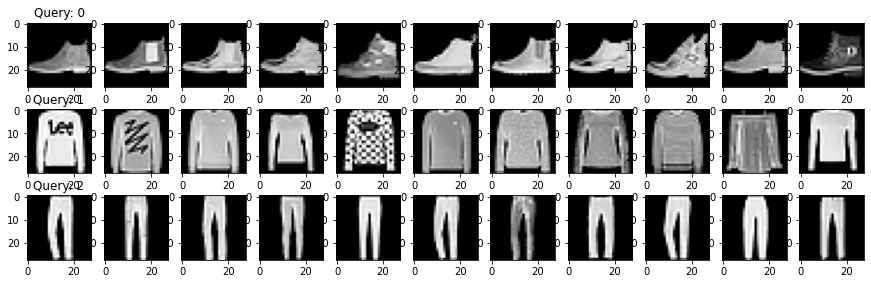

In [12]:
queryCount = 3
queries = embeddings[:queryCount,:].data.numpy()
database = embeddings[queryCount:,:].data.numpy()
plt.figure(figsize=[15, 4.5])
for i in range(queryCount):
    results = np.argsort(np.sum((database-queries[i,:])**2, axis=1))[:10]
    plt.subplot(queryCount, 11, i * 11 + 1)
    plt.title("Query: %i" % i)
    plt.imshow(test_dataset.test_data[i].numpy().reshape([28, 28]), cmap='gray')
    for k in range(10):
        plt.subplot(queryCount, 11, i * 11 + k + 2)
        plt.imshow(test_dataset.test_data[results[k]+queryCount].numpy().reshape([28, 28]), cmap='gray')

# Сегментация изображений (0.5 баллов)

Сегментация изображения - это задача классификации каждого пикселя. Например, вот так (пример из датасета Cityscapes Dataset): 

<img src="https://github.com/aosokin/dl_cshse_ami/blob/master/2021-fall/homeworks_small/shw5/cityscapes_example.png?raw=1" width="600" height="500">

В этом ноутбуке предлагается реализовать модель UNet для двухклассовой сегментации изображений.

In [41]:
from torch.optim.lr_scheduler import StepLR

from tqdm import trange

In [42]:

from utils import WeizmannHorsesDataset, show_sample, plot_batch_with_results, plot_history, mean_accuracy, pixel_accuracy, mean_iou

### Скачивание и чтение данных

В качестве датасета мы будем использовать датасет Weizmann Horse Database (источник: http://www.msri.org/m/people/members/eranb/ раздел - Horse Images), состоящий из черно-белых и цветных фотографий лошадей и разметки на два класса - foreground и background.

In [43]:
! wget http://www.msri.org/people/members/eranb/weizmann_horse_db.tar.gz -O data.tar.gz
! tar -xzf data.tar.gz

--2021-10-05 15:52:35--  http://www.msri.org/people/members/eranb/weizmann_horse_db.tar.gz
Resolving www.msri.org (www.msri.org)... 13.56.152.130, 52.8.193.167
Connecting to www.msri.org (www.msri.org)|13.56.152.130|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.msri.org:443/people/members/eranb/weizmann_horse_db.tar.gz [following]
--2021-10-05 15:52:35--  https://www.msri.org/people/members/eranb/weizmann_horse_db.tar.gz
Connecting to www.msri.org (www.msri.org)|13.56.152.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19538574 (19M) [application/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  18.63M  11.3MB/s    in 1.6s    

2021-10-05 15:52:37 (11.3 MB/s) - ‘data.tar.gz’ saved [19538574/19538574]



In [44]:
data_path = "weizmann_horse_db" 
dataset = WeizmannHorsesDataset(data_path, "test", img_shape = (64,64), color = "rgb")

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


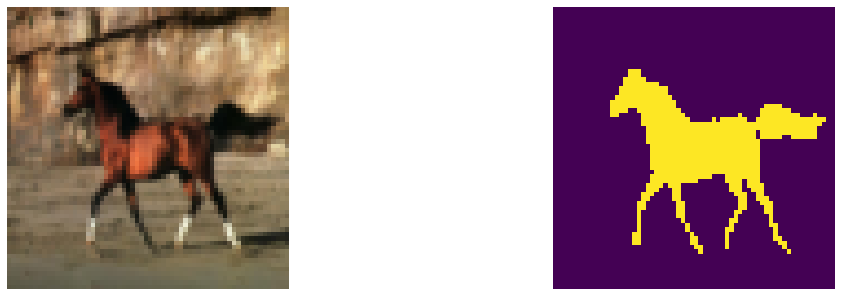

In [45]:
show_sample(dataset, 0)

In [46]:
dataset[0][0].shape

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


torch.Size([3, 64, 64])

## Модель

Схема модели UNet из оригинальной статьи (https://arxiv.org/abs/1505.04597 ):

<img src="https://github.com/aosokin/dl_cshse_ami/blob/master/2021-fall/homeworks_small/shw5/UNet.png?raw=1" width="600" height="500">

На изображении выше синие блоки - карты признаков (feature maps). 

На вход модель принимает исходное изображение, результат модели - сегментация входного изображения (классификация каждого пикселя).

Модель состоит из энкодера (на схеме слева) и декодера (справа).

#### О реализации:

Несколько одинаковых слоев сети, обрабатывающих feature map без изменения размера (например, повторение слоев Conv2d, BatchNorm2d, ReLU) реализованы в классе **ConvBlock**. На изображении один ConvBlock соответствует нескольким подряд идущим синим стрелкам.

В реализации можно не делать crop при копировании feature map, а использовать padding, чтобы размеры карт признаков на одних и тех же уровнях декодера и энкодера совпадали.

Для увеличения размера карты признаков при декодировании (**UpBlock**) вам могут понадобиться nn.ConvTranspose2d или nn.Upsample.

В каждом следующем кодирующем/декодирующем слое **DownBlock**/**UpBlock** предполагается уменьшение/увеличение x-y размеров в $c_1$ раз и увеличение/уменьшение количества каналов в $c_2$ раз. Например, можно взять $c_1 = c_2 = 2$.

In [47]:
class ConvBlock(nn.Module):
    '''
       Convolutional Block, includes several sequential convolutional and activation layers.
       Hint: include BatchNorm here
    '''
    def __init__(self, input_ch, output_ch, kernel_size, block_depth):
        '''
            input_ch - input channels num
            output_ch - output channels num
            kernel_size - kernel size for convolution layers
            block_depth - number of convolution + activation repetitions
        '''
        super().__init__()
        
        conv_list = []
        for i in range(block_depth):
            x = output_ch
            if i == 0:
                x = input_ch
            conv_list.append(nn.Conv2d(x, output_ch, kernel_size, padding=kernel_size // 2))
            conv_list.append(nn.BatchNorm2d(output_ch))
            conv_list.append(nn.ReLU())

        self.conv_net = nn.Sequential(*conv_list)

    def forward(self, x):
        x = self.conv_net(x)
        return x
    
    
class DownBlock(nn.Module):
    '''
        Encoding block, includes pooling (for shape reduction) and Convolutional Block (ConvBlock)
    '''
    def __init__(self, input_ch, output_ch, kernel_size, block_depth):
        super().__init__()
        
        self.dblock = ConvBlock(input_ch, output_ch, kernel_size, block_depth)
        self.dpool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.dblock(x)
        y = x.clone()
        x = self.dpool(x)
        return x, y


class UpBlock(nn.Module):
    '''
        Decoding block, includes upsampling and Convolutional Block (ConvBlock)
    '''
    def __init__(self, input_ch, output_ch, kernel_size, block_depth):
        super().__init__()
        
        self.usamp = nn.Upsample(scale_factor=2)
        self.upconv = nn.ConvTranspose2d(input_ch, input_ch // 2, 1)
        self.ublock = ConvBlock(input_ch, output_ch, kernel_size, block_depth)
        

    def forward(self, copied_input, lower_input):
        '''
            copied_input - feature map from one of the encoder layers
            lower_input - feature map from previous decoder layer
        '''
        # print(lower_input.shape)
        x = self.upconv(lower_input)
        # print('!')
        x = self.usamp(x)
        # print(copied_input.shape)
        # print(x.shape)
        # print('!!!!')
        assert copied_input.shape[-2:] == x.shape[-2:]
        x = torch.cat((copied_input, x), dim=-3)
        # print(x.shape)
        x = self.ublock(x)
        # print(x.shape)
        # print('!!!!!!!!!!!!!!!!!!')
        return x


In [48]:
class UNet(nn.Module):
    def __init__(self, n_classes, feature_levels_num, input_ch_size, hidden_ch_size, block_depth, kernel_size = 3):
        """
        Input:
            n_classes - number of classes
            feature_levels_num - number of down- and up- block levels
            input_ch_size - input number of channels (1 for gray images, 3 for rgb)
            hidden_ch_size - output number of channels of the first Convolutional Block (in the original paper - 32)
            block_depth - number of convolutions + activations in one Convolutional Block
            kernel_size - kernel size for all convolution layers
        """
        super(UNet, self).__init__()
        self.input_block = ConvBlock(input_ch_size, hidden_ch_size, 1, block_depth)
        self.down_blocks = []
        self.up_blocks = []
        self.feature_levels_num = feature_levels_num
        
        
        cur_ch_num = hidden_ch_size
        for _ in range(feature_levels_num):
            # your code
            # fill self.down_blocks and self.up_blocks with DownBlock/UpBlock
            # each DownBlock/UpBlock increase/decrease number of channels by 2 times
            self.down_blocks.append(DownBlock(cur_ch_num, 2 * cur_ch_num, kernel_size, block_depth))
            self.up_blocks.append(UpBlock(4 * cur_ch_num, 2 * cur_ch_num, kernel_size, block_depth))
            cur_ch_num *= 2
        
        self.middle_block = ConvBlock(cur_ch_num, 2 * cur_ch_num, kernel_size, block_depth)
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)
        self.output_block = ConvBlock(hidden_ch_size * 2, n_classes, 1, block_depth)

    def forward(self, x):
        x = self.input_block(x)
        
        feature_maps = []
        for i in range(self.feature_levels_num):
            x, y = self.down_blocks[i](x)
            feature_maps.append(y)
        x = self.middle_block(x)
        for i in range(self.feature_levels_num)[::-1]:
            x = self.up_blocks[i](feature_maps[i], x)
        
        x = self.output_block(x)
        return x  

## Метрики качества

Для сегментации изображения размера $H \times W$ на множество классов $С$ могут быть рассмотрены следующие метрики:

$$Mean~IoU = \frac{1}{|C|}\sum_{i \in C}\frac{TP_i}{FP_i + TP_i + FN_i}$$

$$Pixel~Accuracy = \frac{\sum_{i \in C}TP_i}{H\times W}$$

$$Mean~Accuracy = \sum_{i \in C}\frac{TP_i}{TP_i + FN_i}$$

## Обучение

In [49]:
from collections import defaultdict

In [50]:
def train_epoch(model, optimizer, train_loader):
    loss_log = []
    model.train()
    for _, (x_batch, y_batch) in zip(trange(len(train_loader)), train_loader):
        optimizer.zero_grad()
        prediction = model(x_batch)
        loss = nn.CrossEntropyLoss()(prediction, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    return loss_log

def test(model, test_loader, train_loader):
    '''
        Computes metrics on both train and test, loss on test
    '''
    history = defaultdict(list)
    model.eval()
    
    for batch_num, (x_batch, y_batch) in zip(trange(len(test_loader)), test_loader):
        pred = model(x_batch)
        ce_loss = nn.CrossEntropyLoss()(pred, y_batch.squeeze()).item()
        pred = torch.argmax(pred, dim = 1) #before: (bs, classes, h, w)
        iou_sum = 0
        pixel_acc_sum = 0
        mean_acc_sum = 0
        for i in range(x_batch.shape[0]):
            iou_sum += mean_iou(pred[i].cpu().squeeze(), y_batch[i].cpu().squeeze())
            pixel_acc_sum += pixel_accuracy(pred[i].cpu().squeeze(), y_batch[i].cpu().squeeze())
            mean_acc_sum += mean_accuracy(pred[i].cpu().squeeze(), y_batch[i].cpu().squeeze())
            
        history["loss_val"].append(ce_loss)
        history["iou_val"].append(iou_sum/x_batch.shape[0])
        history["pixel_acc_val"].append(pixel_acc_sum/x_batch.shape[0])
        history["mean_acc_val"].append(mean_acc_sum/x_batch.shape[0])
        
        if batch_num == 0:
            plot_batch_with_results(x_batch.cpu(), y_batch.cpu(), pred.cpu()) 
            
    for batch_num, (x_batch, y_batch) in zip(trange(len(train_loader)), train_loader):  
        pred = torch.argmax(model(x_batch), dim = 1)
        iou_sum = 0
        pixel_acc_sum = 0
        mean_acc_sum = 0
        for i in range(x_batch.shape[0]):
            pred_squeezed = pred[i].squeeze()
            y_squeezed = y_batch[i].squeeze()
            iou_sum += mean_iou(pred_squeezed, y_squeezed)
            pixel_acc_sum += pixel_accuracy(pred_squeezed, y_squeezed)
            mean_acc_sum += mean_accuracy(pred_squeezed, y_squeezed)
        
        history["iou_train"].append(iou_sum/x_batch.shape[0])
        history["pixel_acc_train"].append(pixel_acc_sum/x_batch.shape[0])
        history["mean_acc_train"].append(mean_acc_sum/x_batch.shape[0])

    return history
    
def train_procedure(model, opt, n_epochs, train_loader, test_loader, scheduler):
    history = defaultdict(list)
    steps = len(train_loader)

    for epoch in range(n_epochs):
        
        train_loss = train_epoch(model, opt, train_loader)
        test_history = test(model, test_loader, train_loader)
        
        history["loss_train"].extend(train_loss)
        history["loss_val"].append((steps * (epoch + 1), np.mean(test_history["loss_val"])))
        
        for key in test_history:
            if (key != "loss_val"):
                history[key].append(np.mean(test_history[key]))
                
        plot_history(history)
        
        print('Epoch number: ', epoch)
        print("Epoch average loss:", np.mean(train_loss))
        print("Epoch validation metrics:")
        print("\tIoU -", history['iou_val'][-1])
        print("\tmean accuracy -", history['mean_acc_val'][-1])
        print("\tpixel acc -", history["pixel_acc_val"][-1])

Подберите параметры сети, обучите модель. Если все сделано правильно, то итоговое значение IoU должно превосходить 0.8.

In [61]:
#your parameters
n_classes = 2
shape = (64,64)
input_ch_size = 3
hidden_ch_size = 32 # my
feature_levels_num = 4 # my
block_depth = 3 # my

batch_size = 8
n_epochs = 10
lr = 0.5
lr_step = 10 
lr_gamma = 0.9

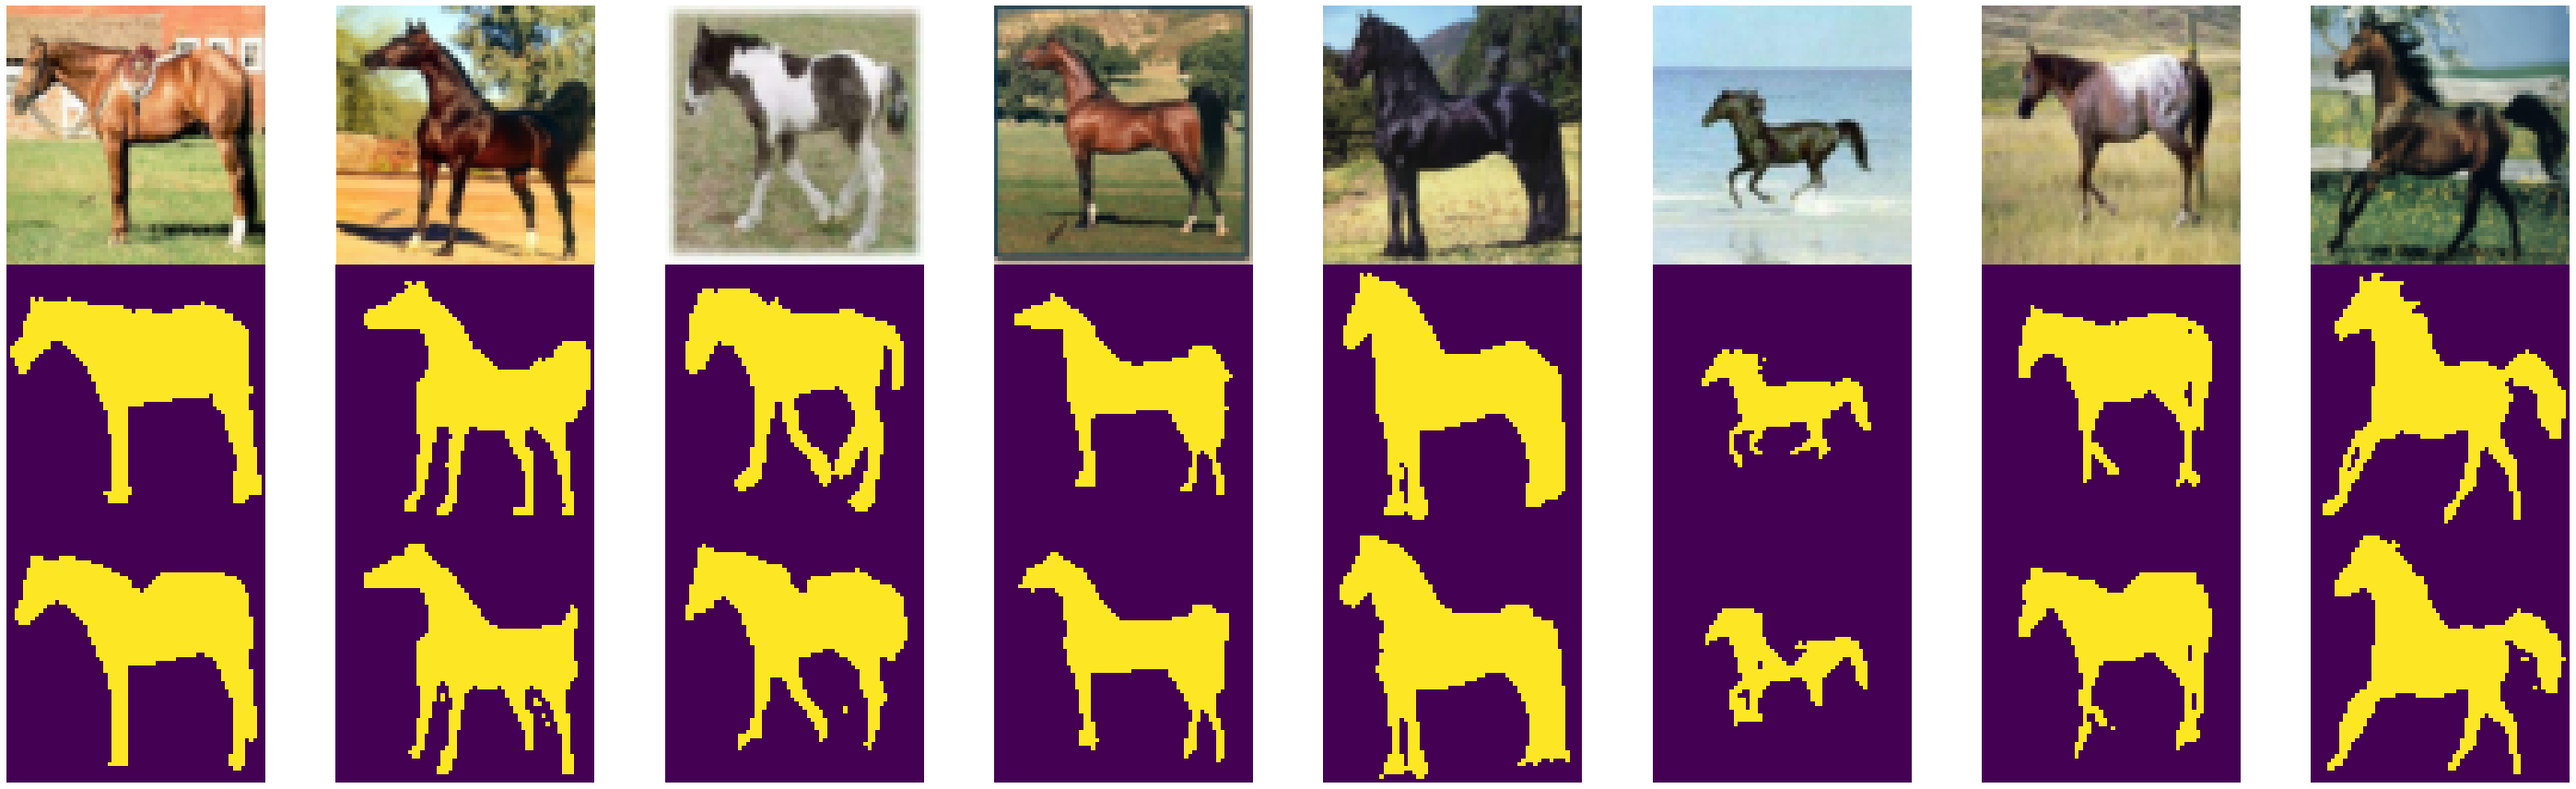

100%|██████████| 33/33 [00:45<00:00,  1.38s/it]


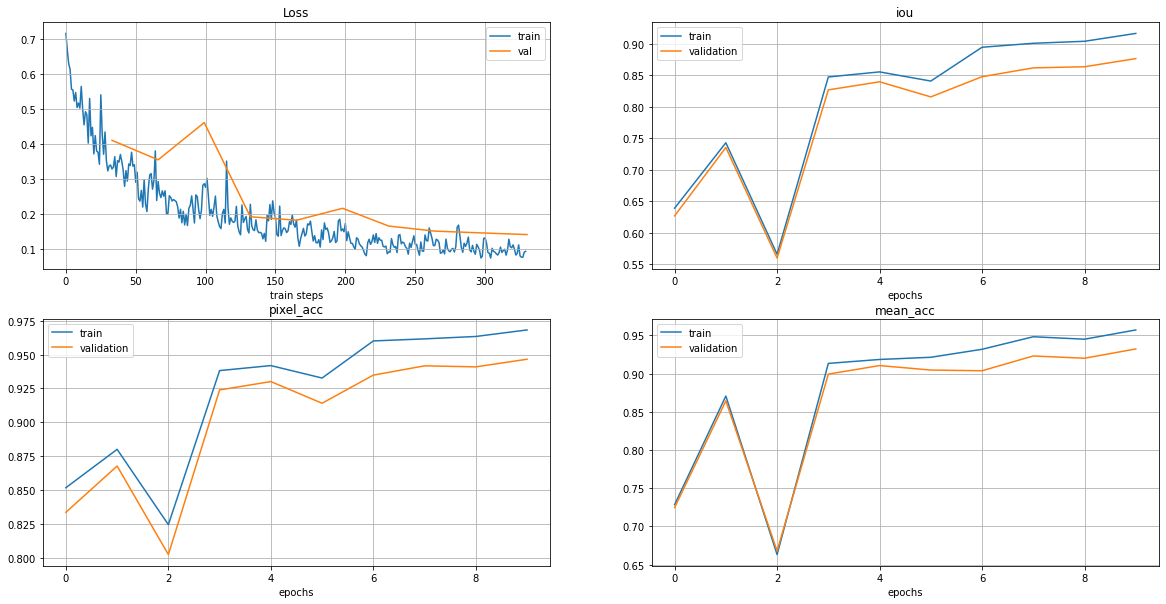

Epoch number:  9
Epoch average loss: 0.09500301742192471
Epoch validation metrics:
	IoU - 0.87679684
	mean accuracy - 0.9322225
	pixel acc - 0.9465705


In [62]:
train_dataset = WeizmannHorsesDataset(root=data_path, split="train", img_shape = shape)
test_dataset = WeizmannHorsesDataset(root=data_path, split="val", img_shape = shape)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle = True)

model = UNet(n_classes, feature_levels_num, input_ch_size, hidden_ch_size, block_depth)

opt = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = StepLR(opt, step_size=lr_step, gamma=lr_gamma)
train_procedure(model, opt, n_epochs, train_loader, test_loader, scheduler = scheduler)